# WGCNA

In [ ]:
nGenes = 6000
ls_cluster = ["1", "3"]
ls_sample = ["0.5 hpi"]
metaSplit = True
fcName = 'sft'
dt_strToPickFc = {
    "sft": lambda x: x["SFT.R.sq"] >= 0.8,
    "k": lambda x: ((x["SFT.R.sq"] >= 0.8) & (x["mean.k."] <= 100)),
}
fc_autoPickSoftPower = dt_strToPickFc[fcName]

In [ ]:
ad_wgcna = ad[ad.obs.eval("leiden_merged in @ls_cluster & Sample in @ls_sample")].copy()
ad_wgcna.obs["temp"] = "a"
ad_wgcna.X = ad_wgcna.layers["raw"].copy()
sc.pp.filter_genes(ad_wgcna, min_cells=5)
sc.pp.pca(ad_wgcna)
sc.pp.neighbors(ad_wgcna)

In [ ]:
ls_hvg = dt_trikuRankInfo['0_1_3'].loc[lambda x:x<=nGenes].index.to_list()

In [ ]:
import importlib
importlib.reload(singleCellTools.plotting)
importlib.reload(singleCellTools.geneEnrichInfo)

In [ ]:
ad_MetaWgcna = singleCellTools.geneEnrichInfo.scWGCNA(
    ad_wgcna,
    "raw",
     ["leiden_merged", "Sample"],
    False,
    target_metacell_size=5e4,
    dir_result=f"{dir_result}/wgcna/",
    jobid="ad_epiCor_M0.5_0801",
    ls_hvgGene=ls_hvg,
    mergeCutHeight=0.15,
    softPower="auto",
    fc_autoPickSoftPower=fc_autoPickSoftPower,
    calcAucell=True
)

In [ ]:
# toPkl(ad_MetaWgcna, 'ad_MetaWgcna_20220801', 'ipf', dir_path=dir_temp)

In [ ]:
ad_MetaWgcna = loadPkl('ad_MetaWgcna_20220801', lambda **dt:sc.read_h5ad(**dt), arg_path='filename', dir_path=dir_temp)

In [ ]:
df_kme = (
    ad_MetaWgcna.varm["KME"]
    .loc[["MTR_7g073660", "MTR_5g086130", "MTR_5g083030"]]
    .copy()
)
df_tom = pd.DataFrame(
    ad_MetaWgcna.varp["TOM"],
    index=ad_MetaWgcna.var.index,
    columns=ad_MetaWgcna.var.index,
).copy()
df_tomRank = df_tom.rank(ascending=False, axis=1)

df_tomRank.loc[
    ["MTR_7g073660", "MTR_5g086130", "MTR_5g083030"],
    ["MTR_7g073660", "MTR_5g086130", "MTR_5g083030"],
]

In [ ]:
# df_turquoiseGenes = ad_MetaWgcna.varm["KME"].query("module == 'turquoise'").iloc[:, -2:]
# df_turquoiseGenes.assign(Name = lambda df:df.index.map(dt_locus2name)).fillna('').to_excel(f"{dir_result}/wgcna_turquoise_20220801.xlsx")

In [ ]:
# df_tomRank.loc["MTR_7g073660"].sort_values().to_frame().astype(int).assign(
#     Name=lambda df: df.index.map(dt_locus2name)
# ).fillna("").to_excel(f"{dir_result}/wgcna_turquoise_FER_rank_20220801.xlsx")

In [ ]:
# df_tomRank.loc["MTR_5g086130"].sort_values().to_frame().astype(int).assign(
#     Name=lambda df: df.index.map(dt_locus2name)
# ).fillna("").to_excel(f"{dir_result}/wgcna_turquoise_LYK3_rank_20220801.xlsx")

In [ ]:
# dt_moduleGenes = ad_MetaWgcna.uns['ad_epiCor_M0.5_0704_wgcna']['genes']
dt_moduleGenes = ad_MetaWgcna.uns['ad_epiCor_M0.5_0801_wgcna']['genes']

In [ ]:
dt_moduleGenes = dt_moduleGenes.keys() >> F(filter, lambda x: x!= 'grey') >> F(lambda a: {x:dt_moduleGenes[x] for x in a})

In [ ]:
singleCellTools.geneEnrichInfo.getAUCellScore(
    ad_wgcna, dt_moduleGenes, 'raw', threads=len(dt_moduleGenes), label='wgcna_auc'
)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [ ]:
dt_moduleSnfGenes = {x:[z for z in y if z in ls_snfGenes] for x,y in dt_moduleGenes.items()}

In [ ]:
df_tom = pd.DataFrame(
    ad_MetaWgcna.varp["TOM"],
    index=ad_MetaWgcna.var.index,
    columns=ad_MetaWgcna.var.index,
).copy()
df_tomRank = df_tom.loc[dt_moduleGenes["turquoise"]].rank(ascending=False)

In [ ]:
grDevices = importr('grDevices')
def rgb_to_hex(r, g, b):
    return ('#{:02X}{:02X}{:02X}').format(r, g, b)
name2hex = lambda x:rgb_to_hex(*grDevices.col2rgb(x))
ls_moduleAllGenes = ad_MetaWgcna.varm['KME'].query("module != 'grey'").sort_values('module').index.to_list()

In [ ]:
ls_moduleAllGenes.index("MTR_7g073660"), ls_moduleAllGenes.index("MTR_5g086130"), ls_moduleAllGenes.index("MTR_5g083030")

(1934, 1628, 1620)

([], [])

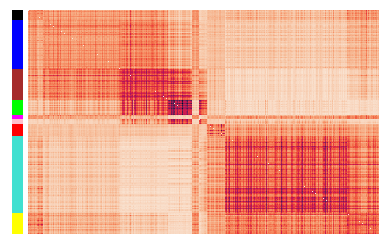

In [ ]:
axs = sns.clustermap(
    ad_MetaWgcna[:, ls_moduleAllGenes].varp["TOM"],
    cmap="rocket_r",
    vmax=0.2,
    row_colors=ad_MetaWgcna[:, ls_moduleAllGenes]
    .varm["KME"]["module"]
    .map(name2hex)
    .to_numpy(),
    col_cluster=False,
    row_cluster=False,
    cbar_pos=None,
    dendrogram_ratio=0, figsize=(6,4)
)
plt.sca(axs.ax_heatmap)
plt.xticks([])
plt.yticks([])

453


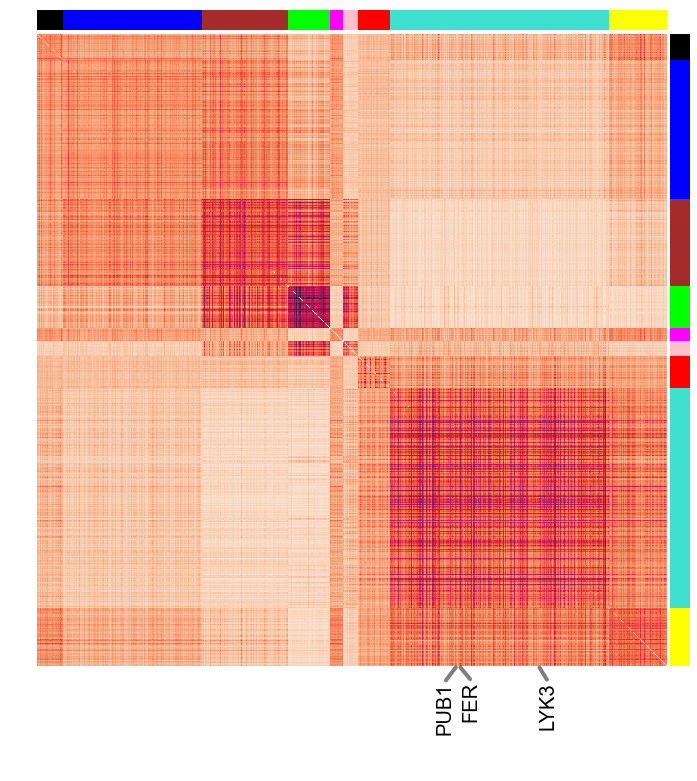

In [ ]:
axs = sns.clustermap(
    ad_MetaWgcna[:, ls_moduleAllGenes].varp["TOM"],
    cmap="rocket_r",
    vmax=0.2,
    row_colors=ad_MetaWgcna[:, ls_moduleAllGenes]
    .varm["KME"]["module"]
    .map(name2hex)
    .to_numpy(),
    col_colors=ad_MetaWgcna[:, ls_moduleAllGenes]
    .varm["KME"]["module"]
    .map(name2hex)
    .to_numpy(),
    col_cluster=False,
    row_cluster=False,
    cbar_pos=None,
    dendrogram_ratio=0,
)
plt.sca(axs.ax_heatmap)
plt.xticks([])
plt.yticks([])

pos_axRowColor = axs.ax_row_colors.get_position()
pos_axHeatmap = axs.ax_heatmap.get_position()
axs.ax_row_colors.set_position(
    [
        pos_axHeatmap.x1 + 0.005,
        pos_axRowColor.y0,
        pos_axRowColor.x1 - pos_axRowColor.x0,
        pos_axRowColor.y1 - pos_axRowColor.y0,
    ]
)

ax = axs.ax_heatmap.figure.add_axes([0, 1, 1, 1])
plt.sca(ax)
pos_axHeatmap = axs.ax_heatmap.get_position()
ax.set_position(
    [
        pos_axHeatmap.x0,
        pos_axHeatmap.y0 - 0.15,
        pos_axHeatmap.x1 - pos_axHeatmap.x0,
        0.15,
    ]
)
plt.xlim(axs.ax_heatmap.get_xlim())
plt.ylim((0, 100))
ls_text = []
for pos, name in zip(
    (
        ls_moduleAllGenes.index("MTR_7g073660"),
        ls_moduleAllGenes.index("MTR_5g086130"),
        ls_moduleAllGenes.index("MTR_5g083030"),
    ),
    ["LYK3", "FER", "PUB1"],
):
    text = plt.text(
        pos, 100, name, ha="center", va="top", rotation=90, fontdict=dict(size=20)
    )
    ls_text.append(text)

x = adjust_text(
    ls_text,
    x=np.array(
        np.meshgrid(
            np.linspace(*axs.ax_heatmap.get_xlim(), 1000), np.linspace(90, 100, 30)
        )
    ).T.reshape(-1, 2)[:, 0],
    y=np.array(
        np.meshgrid(
            np.linspace(*axs.ax_heatmap.get_xlim(), 1000), np.linspace(90, 100, 30)
        )
    ).T.reshape(-1, 2)[:, 1],
    lim=1000,
    force_text=(0.1, 0),
    force_points=(0, 0.002),
    expand_text=(1.4, 1),
    arrowprops=dict(arrowstyle="-", color="black", alpha=0.5, lw=4),
    ha="center",
    va="top",
    precision=0.0001,
    arrow_bbox_pos=(0.5, 1),
)
plt.axis("off")
print(x)

plt.show()

In [ ]:
import importlib
importlib.reload(singleCellTools.plotting)

<module 'jpy_tools.singleCellTools.plotting' from '/public1/software/liuzj/scripts/jModule/jpy_tools/singleCellTools/plotting.py'>

In [ ]:
for gene, title in zip(['MTR_7g073660', 'MTR_5g086130', 'MTR_5g083030'],["LYK3", "FER", "PUB1"]):
    bk = singleCellTools.plotting.umapMultiBatch(
        ad[ad.obs.eval("leiden_merged in @ls_cluster")], 
        gene, ['Sample_4', None], 'normalize_log', None, ncols=1, cb_ratio=0.05, horizontal=True, figsize = (2, 1.5), ls_title=title, show=False
    )
    bk.case.set_title(title, pad=10, size=16, x=0.55, style='italic')
    pw.show(bk.savefig())

300


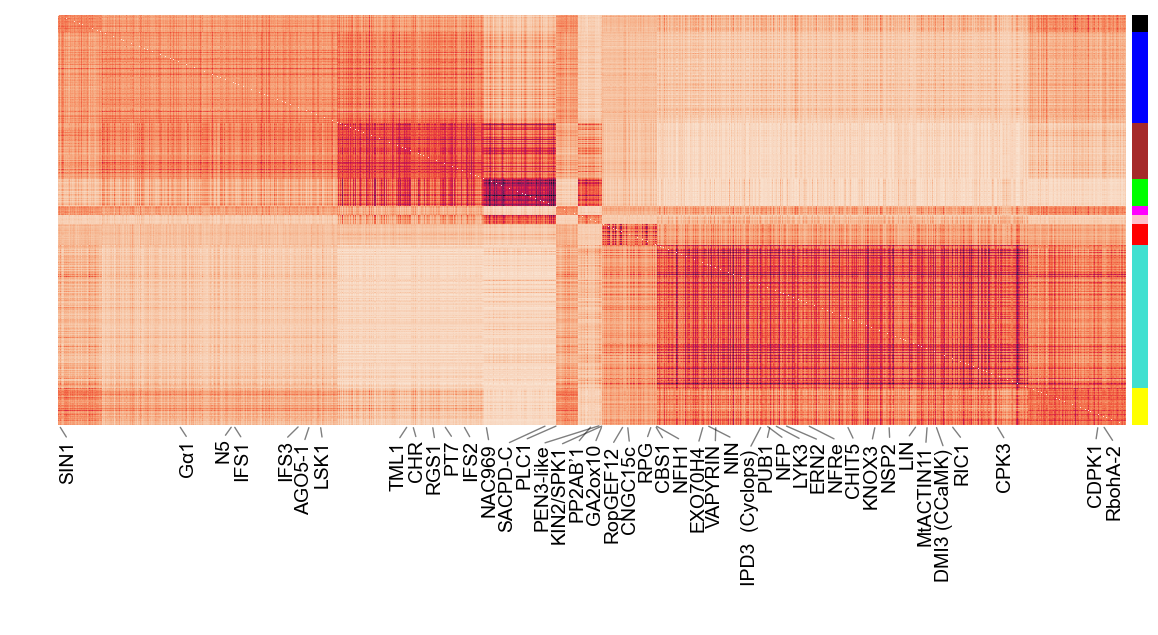

In [ ]:
with plt.rc_context({"figure.dpi": 100}):
    axs = sns.clustermap(
        ad_MetaWgcna[:, ls_moduleAllGenes].varp["TOM"],
        cmap="rocket_r",
        vmax=0.2,
        row_colors=ad_MetaWgcna[:, ls_moduleAllGenes]
        .varm["KME"]["module"]
        .map(name2hex)
        .to_numpy(),
        col_cluster=False,
        row_cluster=False,
        cbar_pos=None,
        dendrogram_ratio=0,
        figsize=(12,5)
    )
    plt.sca(axs.ax_heatmap)
    plt.xticks([])
    plt.yticks([])

    pos_axRowColor = axs.ax_row_colors.get_position()
    pos_axHeatmap = axs.ax_heatmap.get_position()
    axs.ax_row_colors.set_position(
        [
            pos_axHeatmap.x1 + 0.005,
            pos_axRowColor.y0,
            pos_axRowColor.x1 - pos_axRowColor.x0,
            pos_axRowColor.y1 - pos_axRowColor.y0,
        ]
    )

    ax = axs.ax_heatmap.figure.add_axes([0, 1, 1, 1])
    plt.sca(ax)
    pos_axHeatmap = axs.ax_heatmap.get_position()
    ax.set_position(
        [
            pos_axHeatmap.x0,
            pos_axHeatmap.y0 - 0.4,
            pos_axHeatmap.x1 - pos_axHeatmap.x0,
            0.4,
        ]
    )
    plt.xlim(axs.ax_heatmap.get_xlim())
    plt.ylim((0, 100))
    ls_text = []
    for pos, name in zip(
        dt_moduleSnfGenes.values() >> F(list) >> F(sum, ..., []) >> F(map, ls_moduleAllGenes.index) >> F(list),
        dt_moduleSnfGenes.values() >> F(list) >> F(sum, ..., []) >> F(map, dt_locus2name.get) >> F(list),
    ):
        text = plt.text(
            pos, 100, name, ha="center", va="top", rotation=90, fontdict=dict(size=14)
        )
        ls_text.append(text)

    x = adjust_text(
        ls_text,
        x=np.array(
            np.meshgrid(
                np.linspace(*axs.ax_heatmap.get_xlim(), 1000), np.linspace(95, 100, 30)
            )
        ).T.reshape(-1, 2)[:, 0],
        y=np.array(
            np.meshgrid(
                np.linspace(*axs.ax_heatmap.get_xlim(), 1000), np.linspace(95, 100, 30)
            )
        ).T.reshape(-1, 2)[:, 1],
        lim=300,
        force_text=(0.25, 0),
        force_points=(0, 0.002),
        expand_text=(1.02, 1),
        arrowprops=dict(arrowstyle="-", color="black", alpha=0.5, lw=1),
        ha="center",
        va="top",
        precision=0.001,
        avoid_self=False,
        arrow_bbox_pos=(0.5, 1),
    )
    plt.axis("off")
    print(x)

    ax = axs.ax_row_colors
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, (pos.x1 - pos.x0) / 2, pos.y1 - pos.y0])

    plt.show()

In [ ]:
with plt.rc_context({"figure.dpi": 100}):
    fig, ax = plt.subplots(figsize=(6,5))
    _ad = singleCellTools.plotting.obsmToObs(
        ad_wgcna, key_obsm="wgcna_auc"
    )
    sc.pl.umap(_ad, color="turquoise", title="AUC score of turquoise module", cmap="Reds", vmax=0.25, ax=ax)

In [ ]:
_ad = singleCellTools.plotting.obsmToObs(
    ad_wgcna, key_obsm="wgcna_auc"
)
sc.pl.umap(_ad, color="turquoise", title="AUC score of turquoise module", cmap="Reds", vmax=0.25)
axs = sc.pl.umap(_ad, color=_ad.uns['plot_obsm'], cmap="Reds", ncols=2, show=False)
for ax in axs:
    plt.sca(ax)
    plt.title(ax.get_title(), fontsize=24)

In [ ]:
grDevices = importr('grDevices')
def rgb_to_hex(r, g, b):
    return ('#{:02X}{:02X}{:02X}').format(r, g, b)
name2hex = lambda x:rgb_to_hex(*grDevices.col2rgb(x))
ls_moduleAllGenes = ad_MetaWgcna.varm['KME'].query("module != 'grey'").sort_values('module').index.to_list()

In [ ]:
dt_moduleGenes = ad_MetaWgcna.varm["KME"].groupby("module")["GeneSymbol"].agg(list).to_dict()

In [ ]:
module = 'turquoise'
ls_genes = dt_moduleGenes[module]

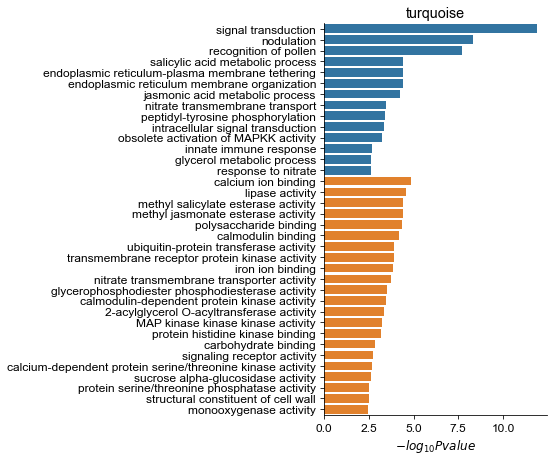

In [ ]:
df_go = enrichmentAnalysisGO(ls_genes, ad.var.index.to_list())
fig, ax = plt.subplots(figsize=(4, df_go.shape[0] * 0.2))
df_go["Description"] = df_go["Description"].str.split(r" \(").str[0]
sns.barplot(
    data=df_go,
    x="-log10Pvalue",
    y="Description",
    hue="Category",
    ax=ax,
    dodge=False,
)
ax.get_legend().remove()
#     plt.legend(loc='lower left', bbox_to_anchor=[-1.2,-0.4], ncol=3, frameon=False)
plt.ylabel("")
plt.xlabel("$-log_{10}Pvalue$")
sns.despine(top=True, right=True)
plt.title(module)
plt.show()

In [ ]:
dt_goColor = {x:y for x,y in zip(['biological_process', 'cellular_component', 'molecular_function'], sns.palettes.color_palette())}

In [ ]:
def _fcSplitGoTerm(x, cutoff=30):
    from more_itertools import chunked
    ls_x = x.split(' ')
    parsed = ''
    lineChrCounts = 0
    for x in ls_x:
        x = x.strip()
        chrCounts = len(x)
        lineChrCounts += chrCounts
        if lineChrCounts > cutoff:
            parsed = parsed + '\n' + x
            lineChrCounts = 0
        else:
            parsed = parsed + ' ' + x
    return parsed

In [ ]:
df_go = enrichmentAnalysisGO(ls_genes, ad.var.index.to_list())
df_go["Description"] = df_go["Description"].str.split(r" \(").str[0].map(_fcSplitGoTerm)

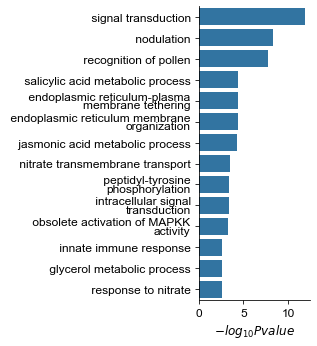

In [ ]:
fig, ax = plt.subplots(figsize=(2, df_go.shape[0] * 0.15))
sns.barplot(
    data=df_go.query("Category == 'biological_process'"),
    x="-log10Pvalue",
    y="Description",
    hue="Category",
    ax=ax,
    dodge=False, palette=dt_goColor
)
plt.legend(loc='lower left', bbox_to_anchor=[-1.2,-0.4], ncol=3, frameon=False)
ax.get_legend().remove()
plt.ylabel("")
sns.despine(top=True, right=True)
plt.yticks(linespacing=0.8)
plt.xlabel("$-log_{10}Pvalue$")
# plt.title(module)
plt.show()

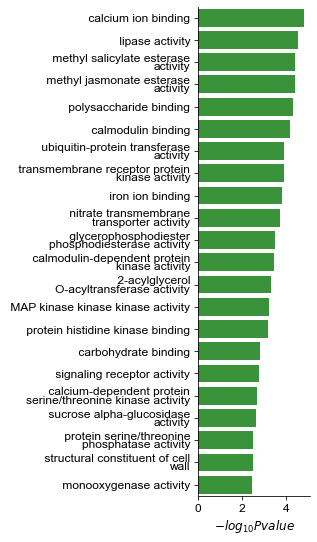

In [ ]:
fig, ax = plt.subplots(figsize=(2, df_go.shape[0] * 0.25))
sns.barplot(
    data=df_go.query("Category == 'molecular_function'"),
    x="-log10Pvalue",
    y="Description",
    hue="Category",
    ax=ax,
    dodge=False, palette=dt_goColor
)
plt.legend(loc='lower left', bbox_to_anchor=[-1.2,-0.4], ncol=3, frameon=False)
ax.get_legend().remove()
plt.ylabel("")
sns.despine(top=True, right=True)
plt.yticks(linespacing=0.8)
plt.xlabel("$-log_{10}Pvalue$")
# plt.title(module)
plt.show()

In [ ]:
for module, ls_genes in dt_moduleGenes.items():
    if module not in ['blue', 'yellow']:
        continue
    df_go = enrichmentAnalysisGO(ls_genes, ad.var.index.to_list())
    if df_go.empty:
        continue
    fig, ax = plt.subplots(figsize=(4, df_go.shape[0] * 0.5))
    df_go["Description"] = df_go["Description"].str.split(r" \(").str[0]
    sns.barplot(
        data=df_go,
        x="-log10Pvalue",
        y="Description",
        hue="Category",
        ax=ax,
        dodge=False,
    )
    ax.get_legend().remove()
    #     plt.legend(loc='lower left', bbox_to_anchor=[-1.2,-0.4], ncol=3, frameon=False)
    plt.ylabel("")
    sns.despine(top=True, right=True)
    plt.title(module)
    plt.show()

In [ ]:
for module, ls_genes in dt_moduleGenes.items():
    df_go = enrichmentAnalysisGO(ls_genes, ad.var.index.to_list())
    if df_go.empty:
        continue
    fig, ax = plt.subplots(figsize=(4, df_go.shape[0] * 0.2))
    df_go["Description"] = df_go["Description"].str.split(r" \(").str[0]
    sns.barplot(
        data=df_go,
        x="-log10Pvalue",
        y="Description",
        hue="Category",
        ax=ax,
        dodge=False,
    )
    ax.get_legend().remove()
    #     plt.legend(loc='lower left', bbox_to_anchor=[-1.2,-0.4], ncol=3, frameon=False)
    plt.ylabel("")
    sns.despine(top=True, right=True)
    plt.title(module)
    plt.show()